# **Pharma Drug Sales – Analysis and Forecasting**

## Introduction

This project aims to analyze and forecast pharmaceutical drug sales using time series data collected from the Point-of-Sale system of a single pharmacy over six years (2024–2019). The primary objective is to uncover underlying patterns in the data and build models capable of making accurate sales forecasts.

## Setup - Installing and loading Packages

In [233]:
import warnings
warnings.filterwarnings('ignore')

The necessary packages — `statsmodels`, `pandas`, `scipy`, `matplotlib`, `numpy` — are installed as follows:

In [234]:
%pip install statsmodels pandas scipy matplotlib numpy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Once installed, the packages are loaded into the environment:

In [235]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from scipy.stats import boxcox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

## Reading the data

The chosen dataset for this study is derived from a Point-of-Sale (POS) system of a single pharmacy, covering a period of six years. The research underlying this project considers eight distinct time series, each summarizing the sales of a specific group of pharmaceutical products. These time series exhibit varying statistical features, offering a diverse foundation for analysis and forecasting.

In [236]:
drug_sales = pd.read_csv('salesweekly.csv')
drug_sales.head()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
0,1/5/2014,14.00,11.67,21.3,185.95,41.0,0.0,32.0,7.0
1,1/12/2014,29.33,12.68,37.9,190.70,88.0,5.0,21.0,7.2
2,1/19/2014,30.67,26.34,45.9,218.40,80.0,8.0,29.0,12.0
3,1/26/2014,34.00,32.37,31.5,179.60,80.0,8.0,23.0,10.0
4,2/2/2014,31.02,23.35,20.7,159.88,84.0,12.0,29.0,12.0


## Preprocessing data

To facilitate data analysis, we will preprocess the data by:
 
**1.** Setting the `date` column as the index 

In [237]:
drug_sales.rename(columns={'datum': 'date'}, inplace=True)
drug_sales['date'] = pd.to_datetime(drug_sales['date'], format='%m/%d/%Y')
drug_sales.set_index('date', inplace=True)

**2.** Creating additional columns, `year` and `week`. These new columns will help track the specific week within each year, which is particularly useful for identifying and analyzing seasonal patterns.

In [238]:
drug_sales['Week'] = drug_sales.index.to_series().dt.isocalendar().week
drug_sales['Year'] = drug_sales.index.to_series().dt.isocalendar().year

## Exploratory Data Analysis

In this study, we will focus on the analysis of the **R06 category**, which includes **antihistamines for systemic use**. This category is particularly relevant due to its consistent demand and significance within the pharmaceutical sector, making it an ideal candidate for exploring time series patterns and building robust forecasting models.

In [239]:
R06 = drug_sales['R06']

### Time plot

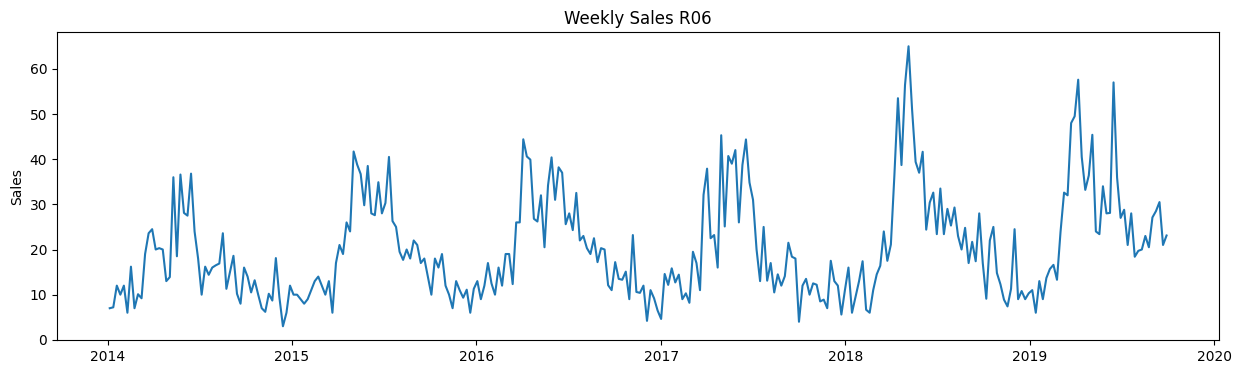

In [272]:
def plot_time_series(data, title, ylabel):
    plt.figure(figsize=(15, 4))
    plt.plot(data.index, data)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.show()

plot_time_series(R06, 'Weekly Sales R06', 'Sales')

### Seasonal Plots

For a clear representation of the seasonal patterns we may use the seasonal plots.

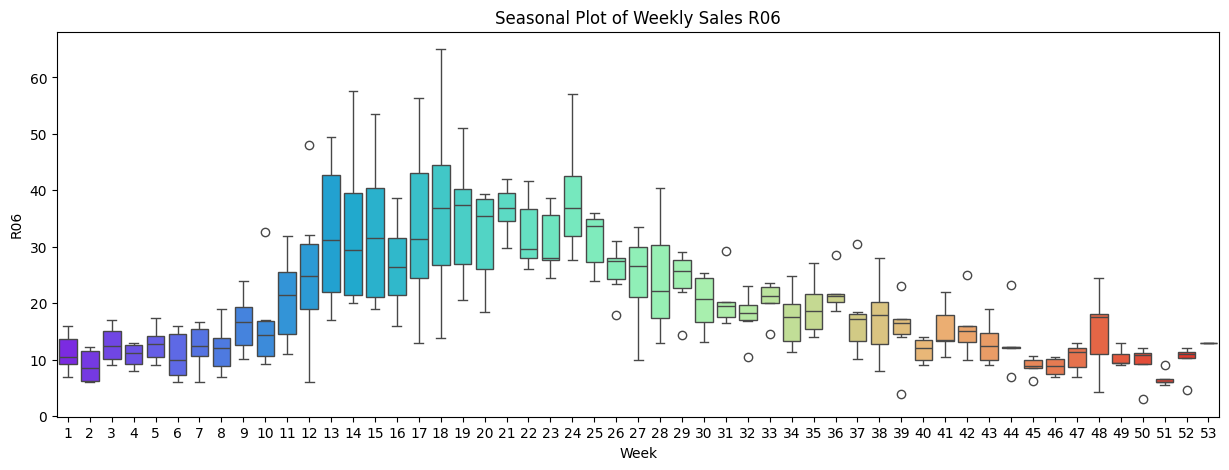

In [241]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=drug_sales, x='Week', y='R06', palette='rainbow')
plt.title('Seasonal Plot of Weekly Sales R06')
plt.show()

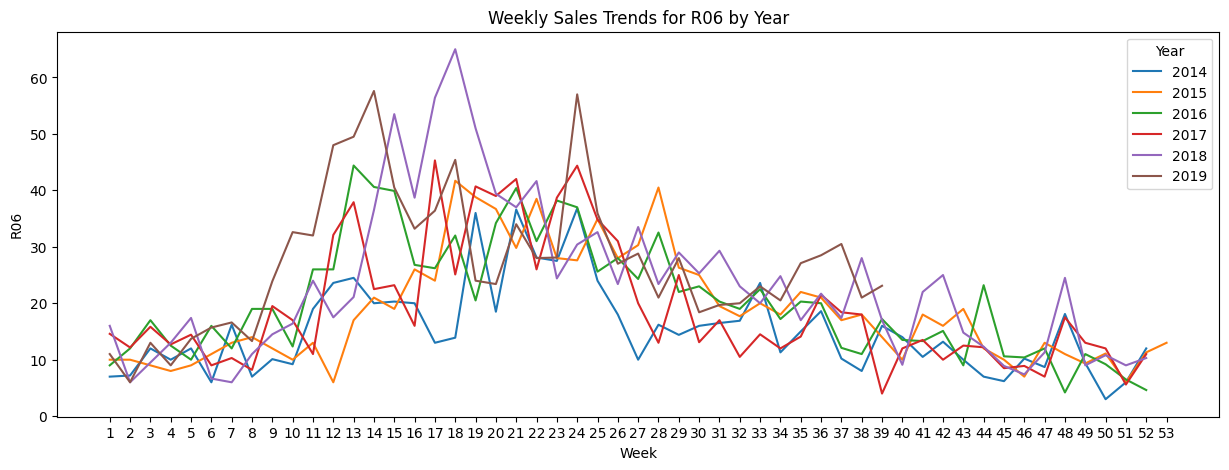

In [242]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=drug_sales, x="Week", y="R06", hue="Year", palette='tab10')
plt.title('Weekly Sales Trends for R06 by Year')
plt.legend(title="Year", loc='upper right')
plt.xticks(ticks=np.arange(1, 54, 1))
plt.show()

### Variance stabilization

To stabilize the variability over the series, the Box-Cox transformations can be applied. One specific case of this transformation is to take the logarithm of the data.

In [243]:
R06_log = np.log(R06)

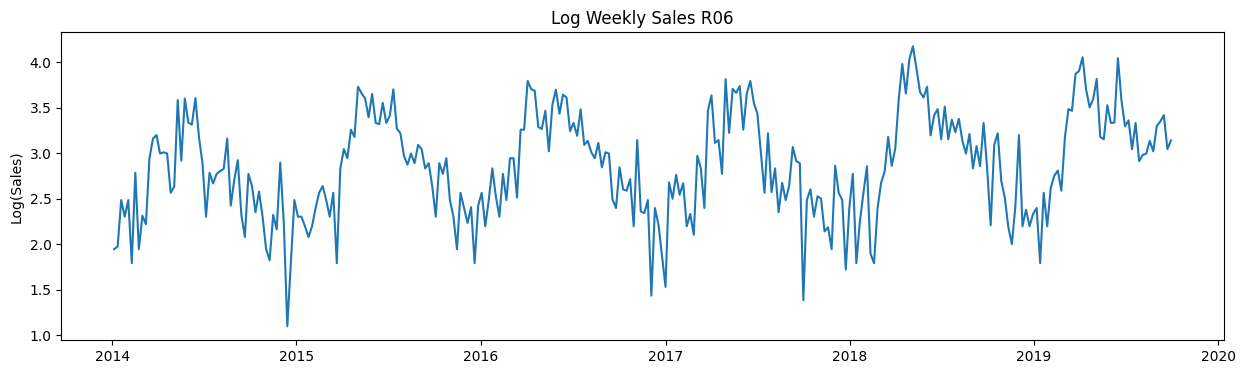

In [274]:
plot_time_series(R06_log, 'Log-transformed Weekly Sales R06', 'Log(Sales)')

### Best Box-Cox transform

To find the best Box-Cox transform - find lambda that minimizes the variance:


In [245]:
R06_boxcox, lambda_R06 = boxcox(R06)
lambda_R06

np.float64(0.10386437165796235)

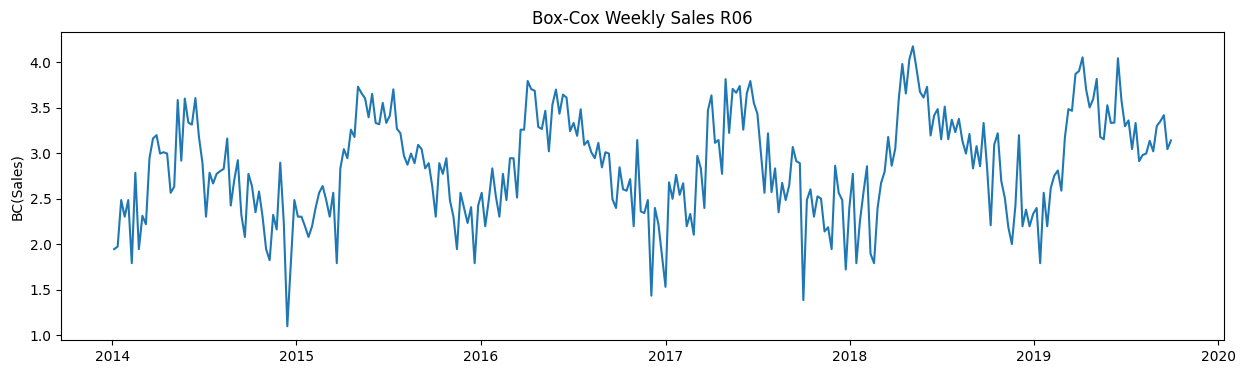

In [ ]:
plot_time_series(R06_log, 'Box-Cox transformed Weekly Sales R06', 'BC(Sales)')

### Seasonal-Trend decomposition using Loess (STL)

The Seasonal Decomposition of Time Series by Loess decomposes a time series into seasonal, trend and irregular components using loess.

In [247]:
stl = STL(R06_log, seasonal=53)
R06_stl = stl.fit()

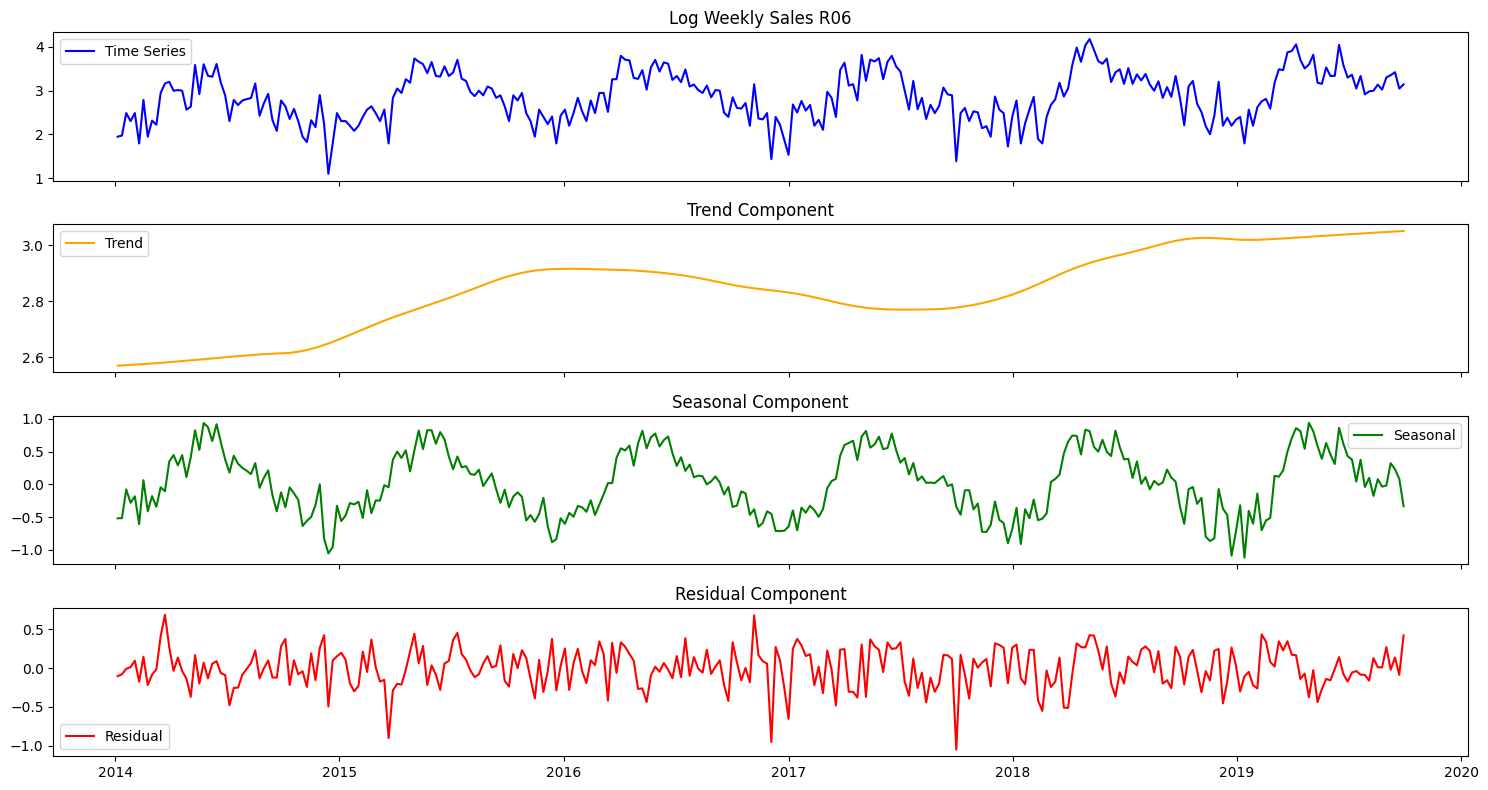

In [248]:
fig, axes = plt.subplots(4, 1, figsize=(15, 8), sharex=True)

axes[0].plot(R06_log, label='Time Series', color='blue')
axes[0].set_title("Log Weekly Sales R06")
axes[0].legend()

# Trend component
axes[1].plot(R06_stl.trend, label='Trend', color='orange')
axes[1].set_title("Trend Component")
axes[1].legend()

# Seasonal component
axes[2].plot(R06_stl.seasonal, label='Seasonal', color='green')
axes[2].set_title("Seasonal Component")
axes[2].legend()

# Residual component
axes[3].plot(R06_stl.resid, label='Residual', color='red')
axes[3].set_title("Residual Component")
axes[3].legend()

plt.tight_layout()
plt.show()

### Autocorrelation Function and Partial Autocorrelation Function

#### Original time series

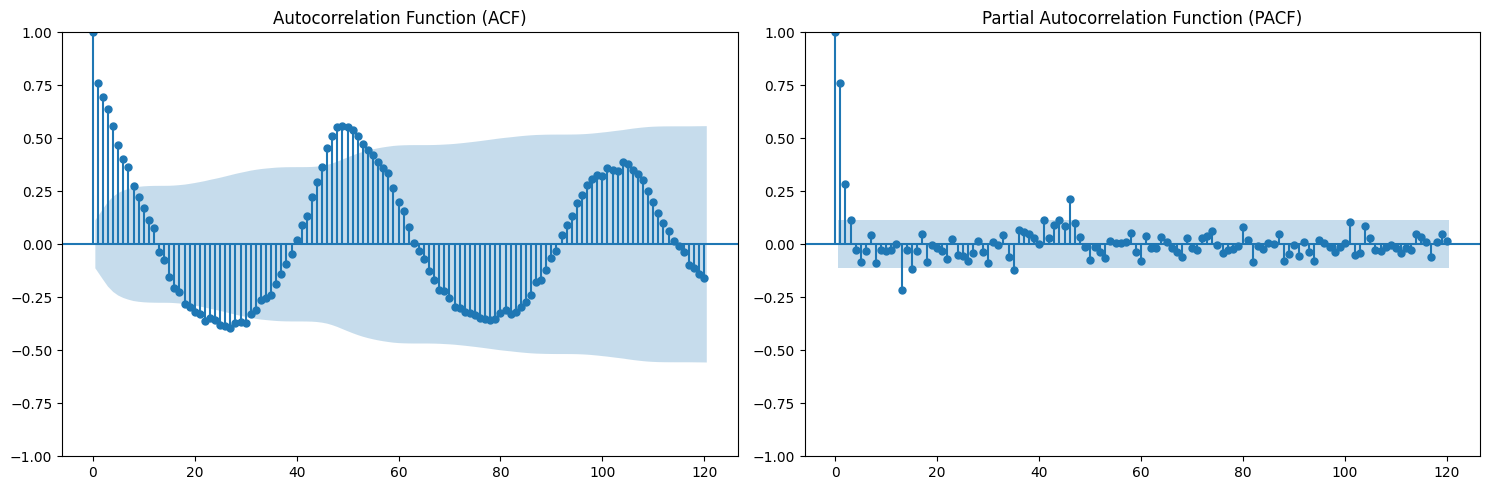

In [249]:
def plot_acf_pacf(data):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    plot_acf(data, lags=120, ax=axes[0])
    axes[0].set_title('Autocorrelation Function (ACF)')

    plot_pacf(data, lags=120, ax=axes[1])
    axes[1].set_title('Partial Autocorrelation Function (PACF)')

    plt.tight_layout()
    plt.show()

plot_acf_pacf(R06)

#### Log-transformed time series

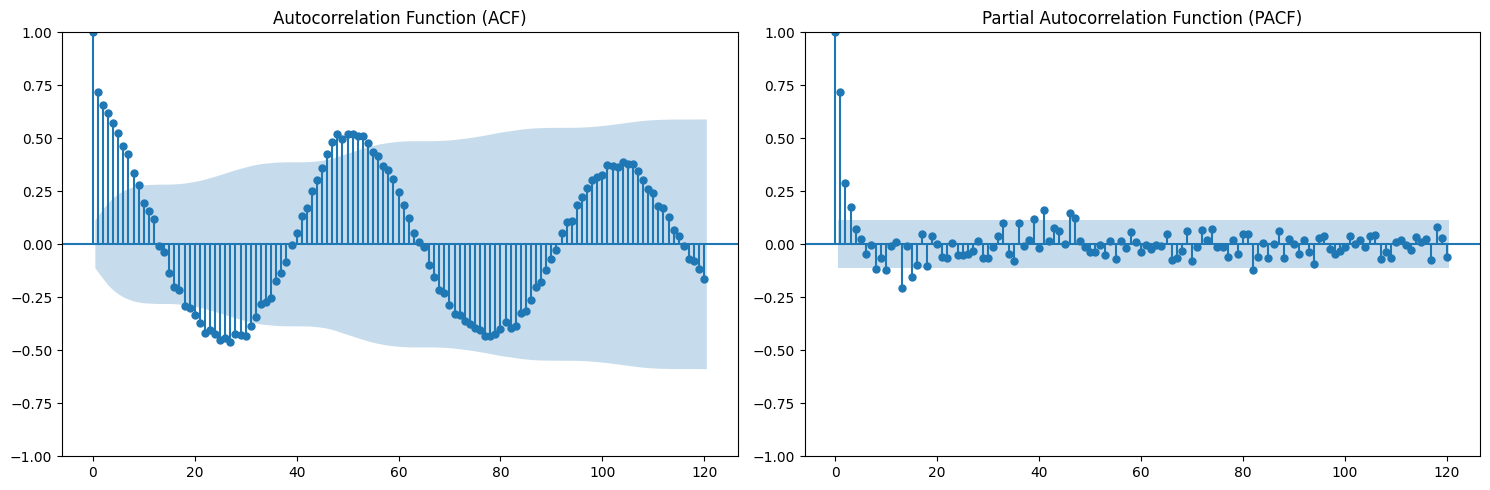

In [250]:
plot_acf_pacf(R06_log)

#### Residuals

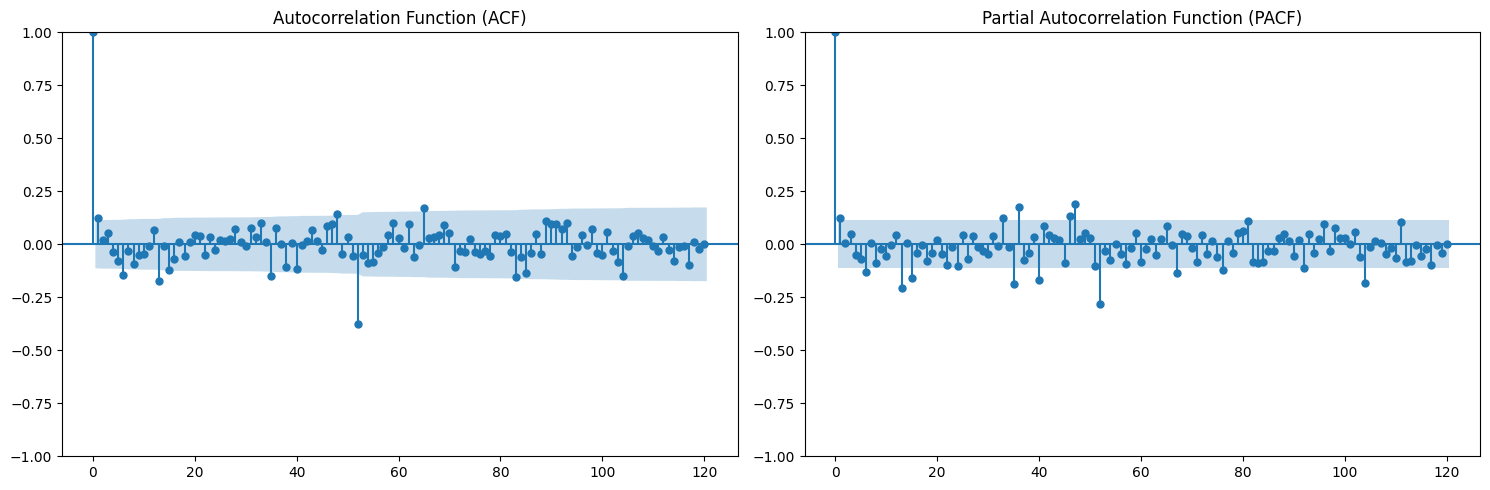

In [251]:
plot_acf_pacf(R06_stl.resid)

### ADF Test

**Null Hypothesis (H0)**: If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

**Alternate Hypothesis (H1)**: The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

source: https://machinelearningmastery.com/time-series-data-stationary-python/

In [282]:
def adf_test(data):
	adf_result, p_value, _, _, critical_values, _ = adfuller(data)
	print('ADF Statistic: %f' % adf_result)
	print('p-value: %f' % p_value)
	print('Critical Values:')
	for key, value in critical_values.items():
		print('\t%s: %.3f' % (key, value))
  
adf_test(R06_log)

ADF Statistic: -5.424644
p-value: 0.000003
Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572


The ADF value is lower than the critical values (and p-value < 0.05) so the log-transformed time series is stationary.

---

## Data Partitioning

The most recent 12 weeks (i.e. 3 months) will be used as the testing set.

In [253]:
train = R06_log[:-12]
test = R06_log[-12:]

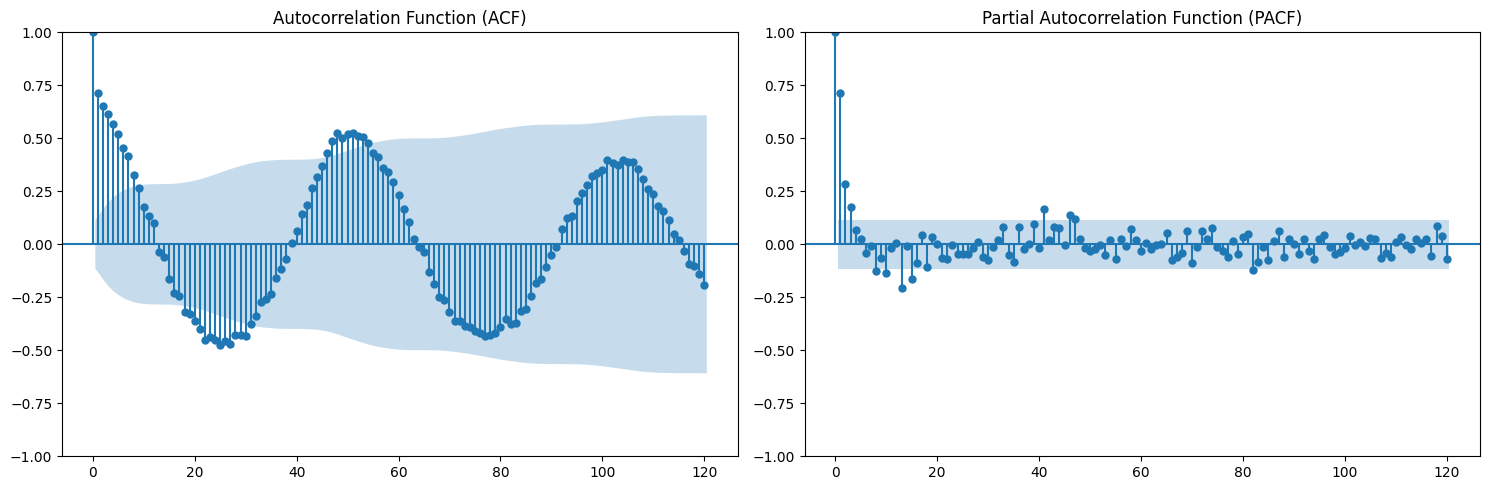

In [254]:
plot_acf_pacf(train)

---

## Modelling

By examining the ACF and PACF plots, we observe that the ACF exhibits a slow decay towards zero, indicating the presence of strong autocorrelation over time. Meanwhile, the PACF shows significant spikes at lags 1, 2, and possibly 3, suggesting that an AR(2) or AR(3) model would be appropriate for capturing the underlying structure of the data.

### 1. AR(2)

In [255]:
ar2_model = SARIMAX(train, order=(2,0,0))
ar2_model_fit = ar2_model.fit()
ar2_ljung_box = acorr_ljungbox(ar2_model_fit.resid, lags=52, return_df=True)

In [256]:
ar2_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    R06   No. Observations:                  288
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -140.555
Date:                Sat, 04 Jan 2025   AIC                            287.111
Time:                        18:19:47   BIC                            298.100
Sample:                    01-05-2014   HQIC                           291.515
                         - 07-07-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6037      0.050     12.044      0.000       0.505       0.702
ar.L2          0.3894      0.050      7.849      0.000       0.292       0.487
sigma2         0.1532      0.011     13.873      0.000       0.132       0.175
===================================================================================
Ljung-Box (L1) (Q):                   2.69   Jarque-Bera (JB):                 7.30
Prob(Q):                              0.10   Prob(JB):                         0.03
Heteroskedasticity (H):               1.24   Skew:                            -0.14
Prob(H) (two-sided):                  0.30   Kurtosis:                         3.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

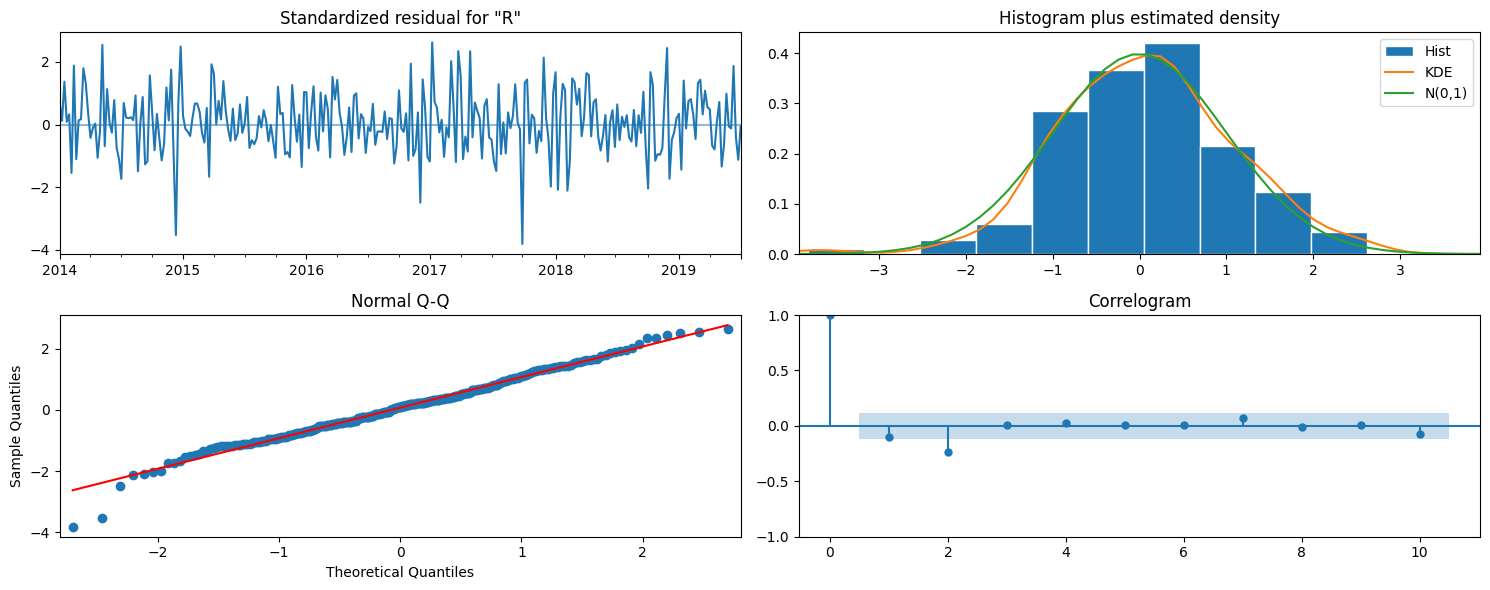

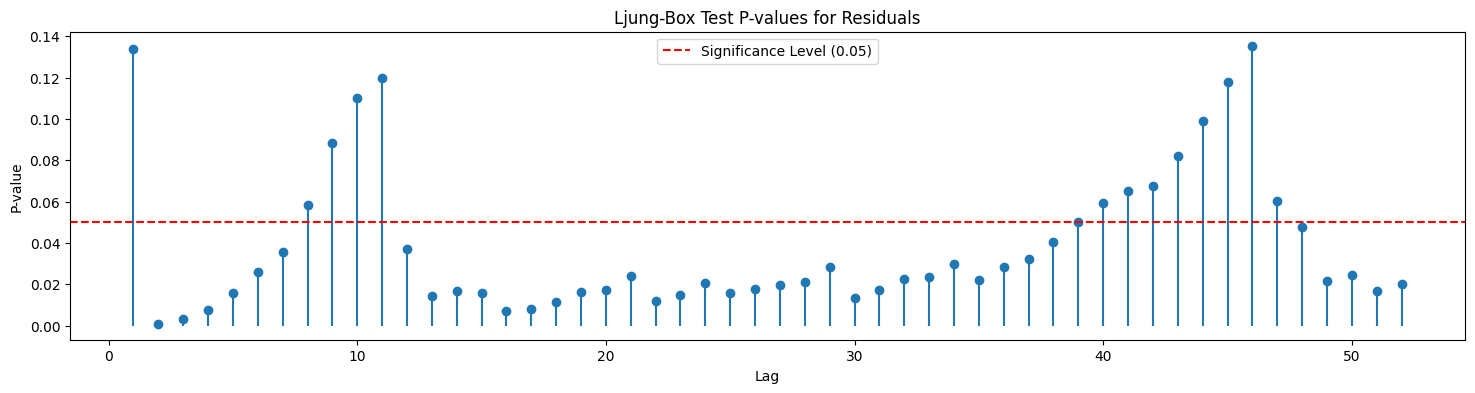

In [257]:
def plot_arima_diagnostics_and_ljungbox(model, ljung_box): 
    fig = plt.figure(figsize=(15, 6))
    model.plot_diagnostics(fig=fig)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(18, 4))
    plt.stem(ljung_box.index, ljung_box['lb_pvalue'], basefmt=" ")
    plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Level (0.05)')
    plt.title('Ljung-Box Test P-values for Residuals')
    plt.xlabel('Lag')
    plt.ylabel('P-value')
    plt.legend()
    plt.show()
    
plot_arima_diagnostics_and_ljungbox(ar2_model_fit, ar2_ljung_box)

#### 2. AR(3)

In [258]:
ar3_model = SARIMAX(train, order=(3,0,0))
ar3_model_fit = ar3_model.fit()
ar3_ljung_box = acorr_ljungbox(ar3_model_fit.resid, lags=52, return_df=True)

In [259]:
ar3_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    R06   No. Observations:                  288
Model:               SARIMAX(3, 0, 0)   Log Likelihood                -132.293
Date:                Sat, 04 Jan 2025   AIC                            272.585
Time:                        18:19:48   BIC                            287.237
Sample:                    01-05-2014   HQIC                           278.457
                         - 07-07-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5110      0.057      8.978      0.000       0.399       0.622
ar.L2          0.2472      0.062      4.016      0.000       0.127       0.368
ar.L3          0.2366      0.059      4.041      0.000       0.122       0.351
sigma2         0.1445      0.010     13.915      0.000       0.124       0.165
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):                 9.39
Prob(Q):                              0.59   Prob(JB):                         0.01
Heteroskedasticity (H):               1.17   Skew:                            -0.21
Prob(H) (two-sided):                  0.43   Kurtosis:                         3.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

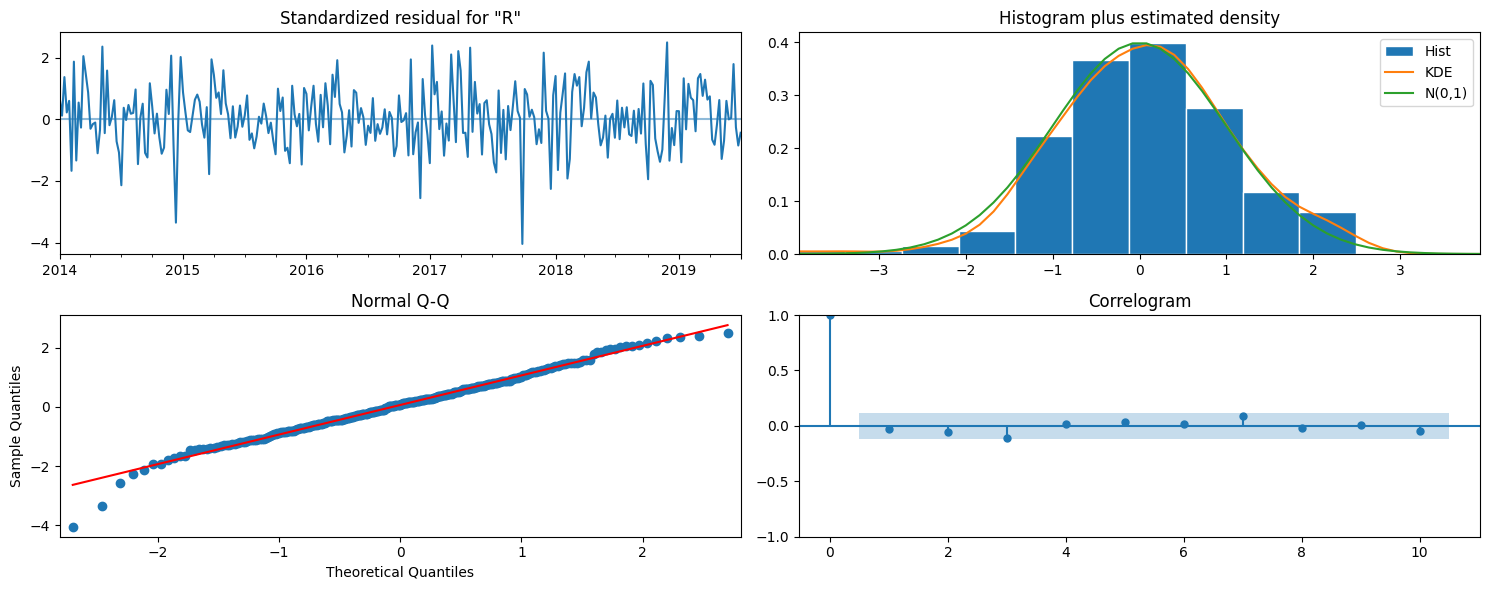

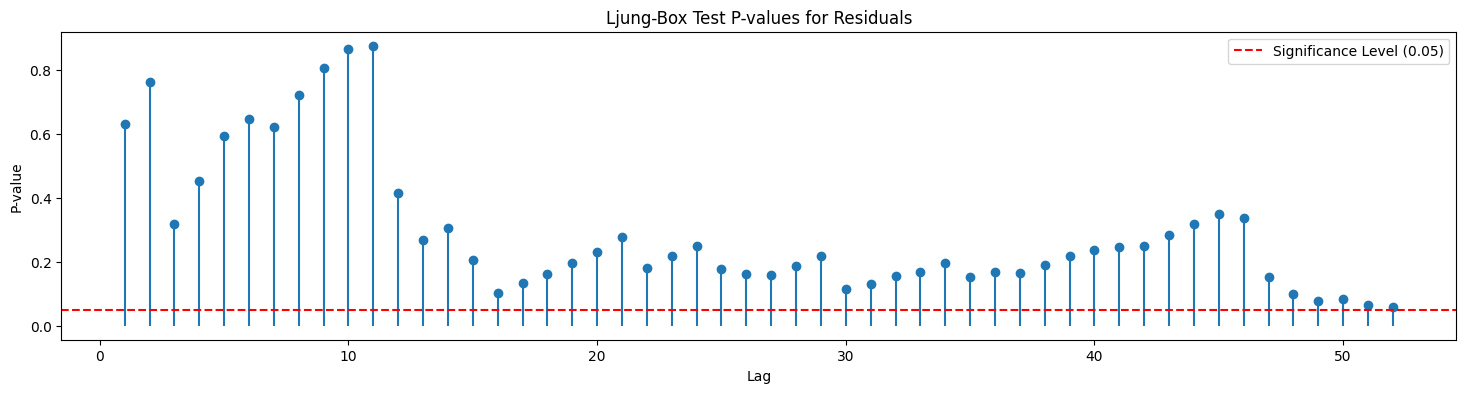

In [260]:
plot_arima_diagnostics_and_ljungbox(ar3_model_fit, ar3_ljung_box)

### 3. SARIMA

In [278]:
R06_seasonal_diff = R06_log.diff(52).dropna()

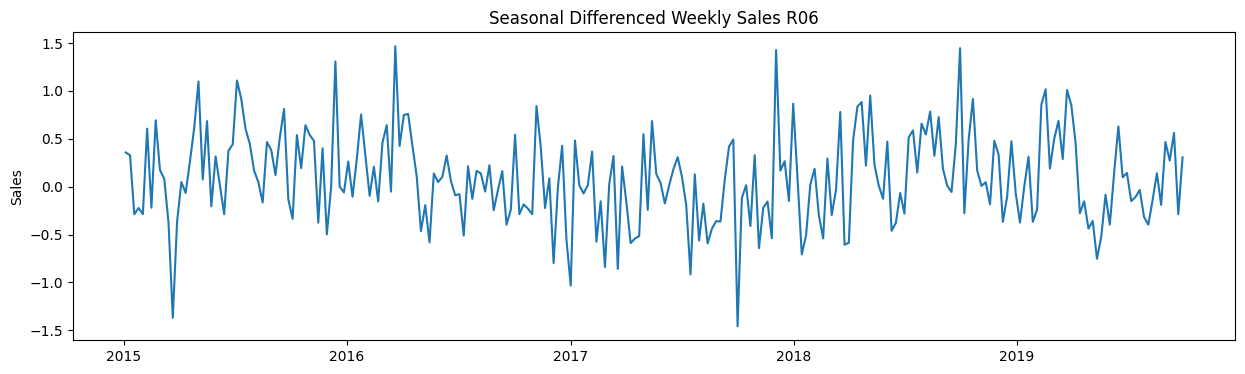

In [279]:
plot_time_series(R06_seasonal_diff, 'Seasonal Differenced Weekly Sales R06', 'Sales')

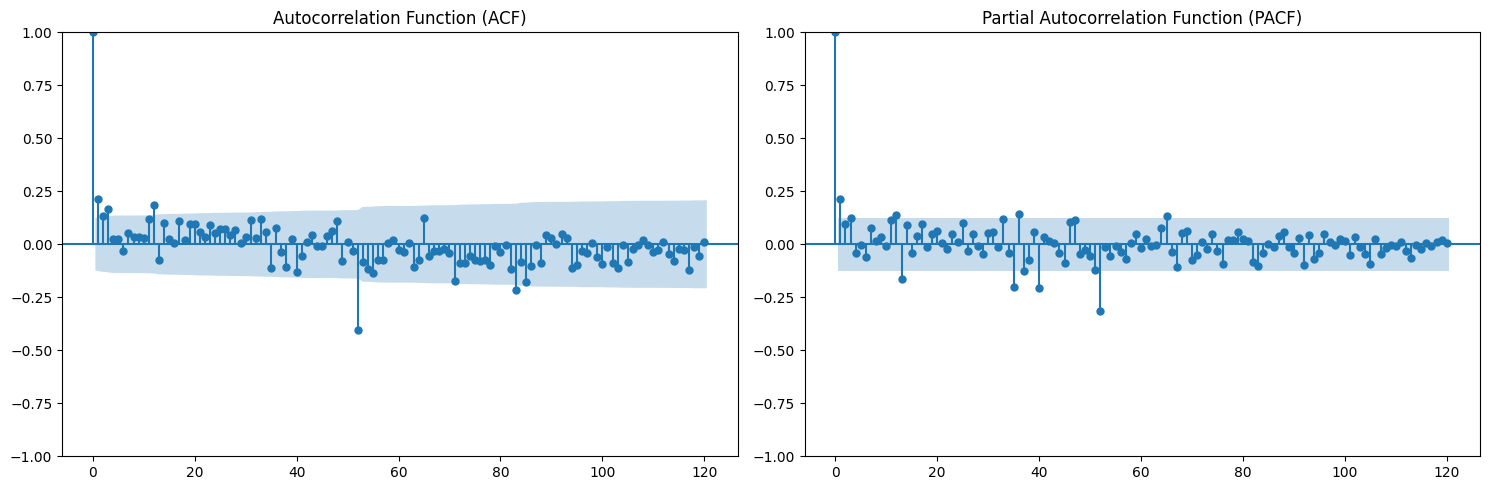

In [280]:
plot_acf_pacf(R06_seasonal_diff)

#### ADF test

In [284]:
adf_test(R06_seasonal_diff)

ADF Statistic: -6.758858
p-value: 0.000000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573


In [301]:
sarima_model = SARIMAX(train, order=(1,0,2), seasonal_order=(1,1,1,52))
sarima_model_fit = sarima_model.fit()
sarima_ljung_box = acorr_ljungbox(sarima_model_fit.resid, lags=52, return_df=True)

In [ ]:
sarima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                  R06   No. Observations:                  288
Model:             SARIMAX(1, 0, 2)x(1, 1, [1], 52)   Log Likelihood                -119.065
Date:                              Sat, 04 Jan 2025   AIC                            250.131
Time:                                      19:13:03   BIC                            270.914
Sample:                                  01-05-2014   HQIC                           258.509
                                       - 07-07-2019                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9936      0.011     91.830      0.000       0.972       1.015
ma.L1         -0.7944      0.065    -12.206      0.000      -0.922      -0.667
ma.L2         -0.1413      0.070     -2.028      0.043      -0.278      -0.005
ar.S.L52      -0.1289      0.136     -0.950      0.342      -0.395       0.137
ma.S.L52      -0.6314      0.197     -3.201      0.001      -1.018      -0.245
sigma2         0.1386      0.015      9.316      0.000       0.109       0.168
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.61
Prob(Q):                              0.97   Prob(JB):                         0.45
Heteroskedasticity (H):               1.06   Skew:                            -0.19
Prob(H) (two-sided):                  0.80   Kurtosis:                         3.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

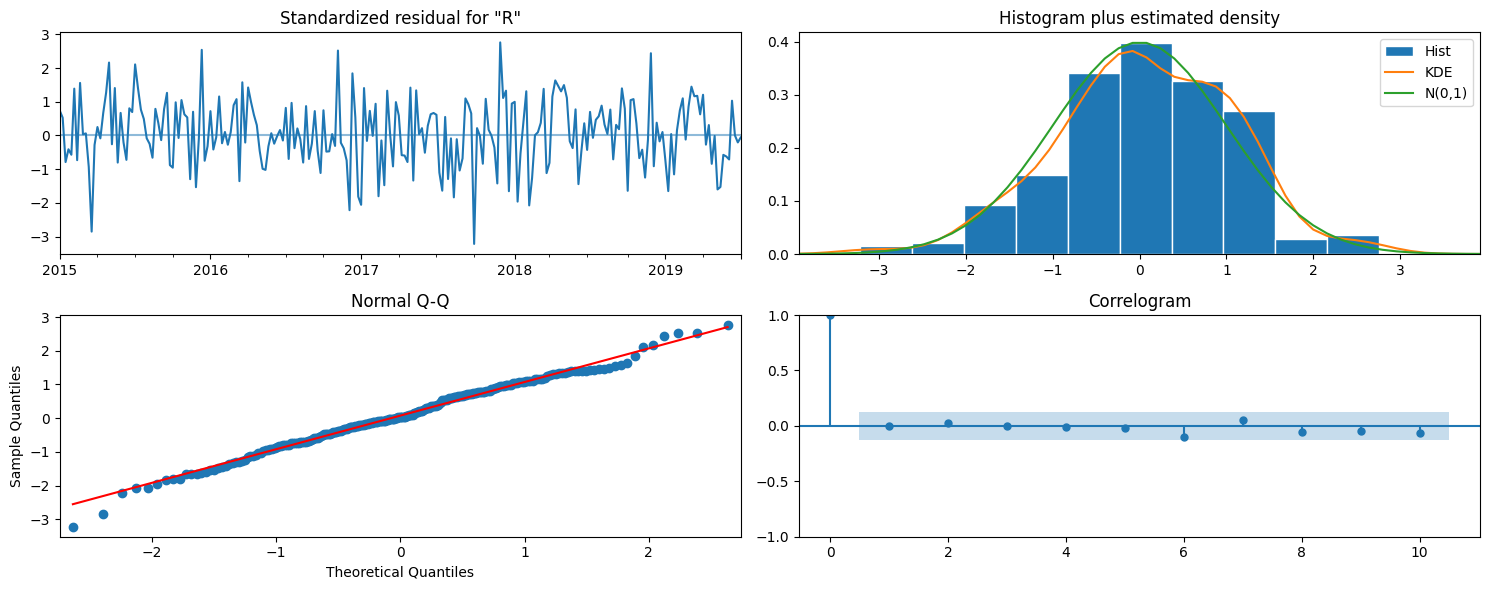

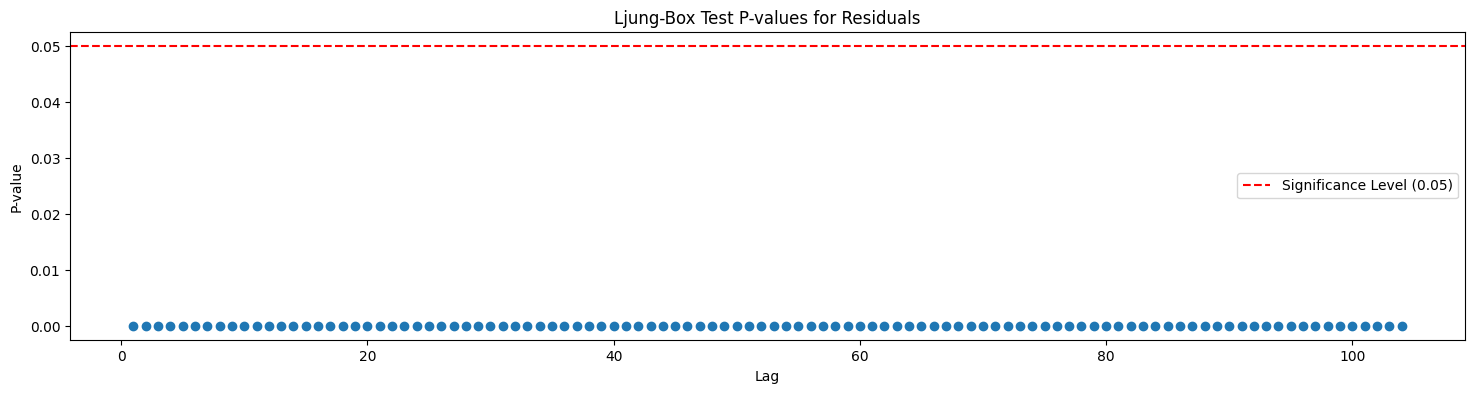

In [303]:
plot_arima_diagnostics_and_ljungbox(sarima_model_fit, sarima_ljung_box)

---

## 4. Forecasting strategies

### 4.1. Forecasting 12-weeks ahead

In [262]:
def forecast(model, test):
    model_fit = model.fit()
    
    predictions = model_fit.forecast(len(test))
    predictions = pd.Series(predictions, index=test.index)
    
    residuals = test - predictions
    return predictions, residuals

predictions, residuals = forecast(ar3_model, test)

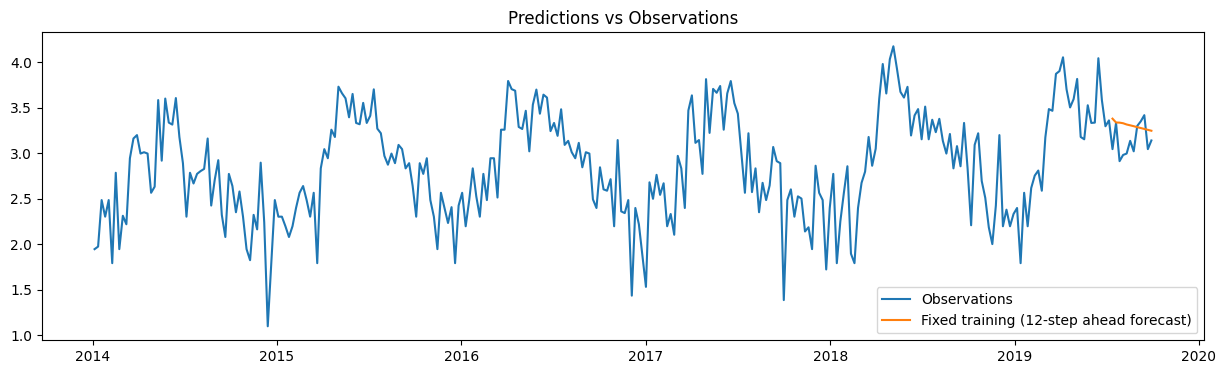

In [263]:
def plot_predictions(time_series, predictions, label):
    plt.figure(figsize=(15, 4))
    plt.plot(time_series, label='Observations')
    plt.plot(predictions, label=label)
    plt.legend(loc='lower right')
    plt.title('Predictions vs Observations')
    plt.show()
    
plot_predictions(R06_log, predictions, 'Fixed training (12-step ahead forecast)')

### 4.2. Forecasting 12 months with 1-step ahead - Interaction

In [264]:
def forecast_rolling_predictions(order, test):
    predictions = test.copy()

    for train_end in test.index:
        train_data = R06_log[:train_end-timedelta(days=1)]

        model = SARIMAX(train_data, order=order)
        model_fit = model.fit()

        last_fitted_value = model_fit.fittedvalues.iloc[-1]
        
        predictions[train_end] = last_fitted_value
        
    residuals = test - predictions
    return predictions, residuals

rolling_predictions, rolling_residuals = forecast_rolling_predictions((3,0,0), test)

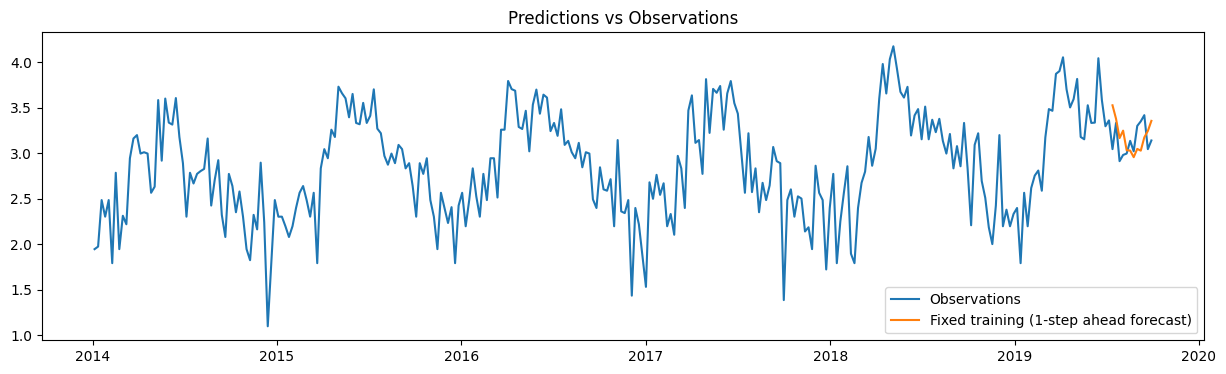

In [265]:
plot_predictions(R06_log, rolling_predictions, 'Fixed training (1-step ahead forecast)')

### 4.3. Forecasting 12 months with 1-step ahead - Expanding windows

In [266]:
def forecast_expanding_windows(order, test):
    predictions = test.copy()

    for train_end in test.index:
        train_data = R06_log[:train_end-timedelta(days=1)]

        model = SARIMAX(train_data, order=order)
        model_fit = model.fit()

        pred = model_fit.forecast()
        predictions[train_end] = pred
        
    residuals = test - rolling_predictions
    return predictions, residuals

expanding_predictions, expanding_residuals = forecast_expanding_windows((3,0,0), test)

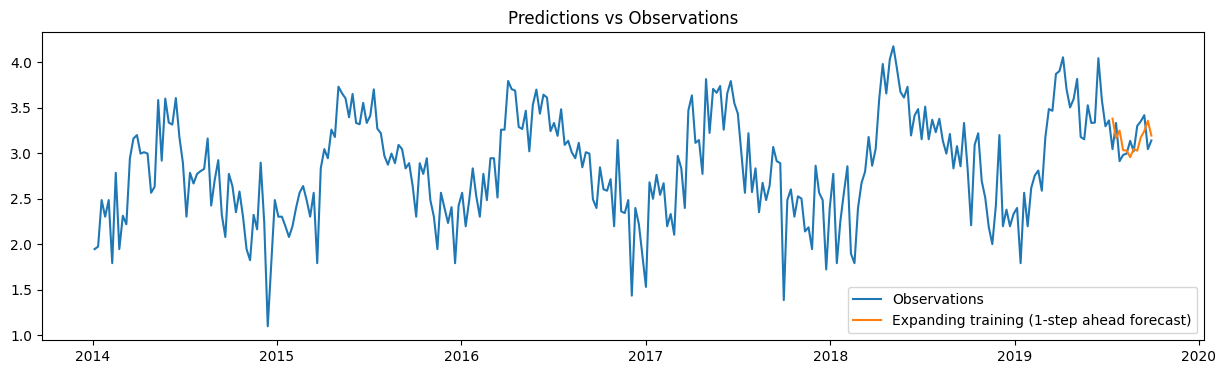

In [267]:
plot_predictions(R06_log, expanding_predictions, 'Expanding training (1-step ahead forecast)')

### 4.4. Forecasting 12 months with 1-step ahead - Recursive windows

In [268]:
def forecast_recursive_windows(order, test):
    predictions = test.copy()
    train_starting_week = train.index[0]

    for i, train_end in enumerate(test.index):    
        train_data = R06_log[train_starting_week+timedelta(days=7*i):train_end-timedelta(days=1)]
        
        model = SARIMAX(train_data, order=order)
        model_fit = model.fit()

        pred = model_fit.forecast()
        predictions[train_end] = pred
        
    residuals = test - predictions
    return predictions, residuals

recursive_predictions, recursive_residuals = forecast_recursive_windows((3,0,0), test)

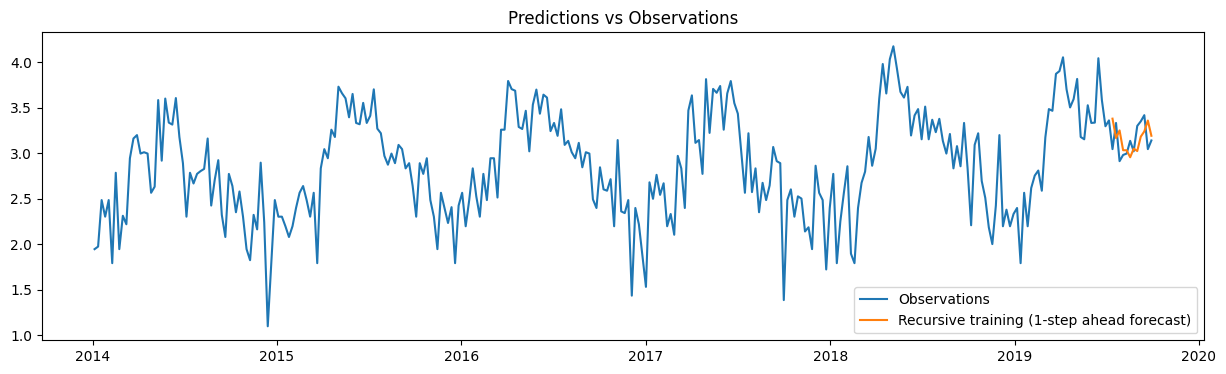

In [269]:
plot_predictions(R06_log, recursive_predictions, 'Recursive training (1-step ahead forecast)')

In [270]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test)),4))

print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Mean Absolute Percent Error: 0.0662
Root Mean Squared Error: 0.24149425652036322
